# Modeling for Target House Features

This workbook ames to predict the value each target feature adds to the house when all other factors are held constant. 

We will use Linear Regression to create our model.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, median_absolute_error
import os
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer

In [3]:
# use absolute path to retrieve datasets

train = pd.read_csv(os.path.abspath('./datasets/cleaned_train.csv'))
test = pd.read_csv(os.path.abspath('./datasets/cleaned_test.csv'))

# sample = pd.read_csv(os.path.abspath('./datasets/sample_sub_reg.csv'))

[source for absolute path](https://stackoverflow.com/questions/51520/how-to-get-an-absolute-file-path-in-python)

In [4]:
train.head()

,id,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,lot_config,...,total_baths,bsmt_finished,size_n_qual,bed_n_bath,fin_bsmt_fin_qual,bsmt_fin_n_ceiling,bsmt_finished_with_bath,bsmt_finished_with_halfbath,bsmt_size_fin_sf,overall_qual_cond
0,109,60,RL,77.504886,13517,2,3,4,4,CulDSac,...,3.0,533.0,8874,9.0,2665.0,533.0,0.0,0.0,386425.0,48
1,544,60,RL,43.000000,11492,2,3,4,4,CulDSac,...,4.0,637.0,14854,16.0,3185.0,1274.0,637.0,0.0,581581.0,35
2,153,20,RL,68.000000,7922,2,4,4,4,Inside,...,2.0,731.0,5285,6.0,3655.0,731.0,731.0,0.0,772667.0,35
3,318,60,RL,73.000000,9802,2,4,4,4,Inside,...,3.0,0.0,7220,9.0,0.0,0.0,0.0,0.0,0.0,25
4,255,50,RL,82.000000,14235,2,3,4,4,Inside,...,2.0,0.0,8670,6.0,0.0,0.0,0.0,0.0,0.0,48


In [5]:
train.columns

Index(['id', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area', 'street',
       'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope',
       'neighborhood', 'condition_1', 'condition_2', 'bldg_type',
       'house_style', 'overall_qual', 'overall_cond', 'year_built',
       'year_remod/add', 'roof_style', 'roof_matl', 'exterior_1st',
       'exterior_2nd', 'mas_vnr_type', 'mas_vnr_area', 'exter_qual',
       'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
       'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2',
       'bsmt_unf_sf', 'total_bsmt_sf', 'heating', 'heating_qc', 'central_air',
       'electrical', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf',
       'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath',
       'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'kitchen_qual',
       'totrms_abvgrd', 'functional', 'fireplaces', 'fireplace_qu',
       'garage_type', 'garage_yr_blt', 'garage_finish', 'garage_cars',
       

In [6]:
drop_lst = []
drop_lst.extend(['pool_area',  #not applicable to most homes
                'enclosed_porch',
                '3ssn_porch',
                'screen_porch',
                'garage_yr_blt',
                'functional',
               'low_qual_fin_sf',
                'garage_qual',
                'paved_drive', 
                'central_air',
                'bsmtfin_sf_2',
                'kitchen_abvgr',
               'utilities',
               'land_slope', 
               'lot_area',
               'street',
               'land_slope', 
                'yr_sold',
                'bsmtfin_type_2',
                 'bsmtfin_sf_2',
                'exterior_2nd',
                'heating',
                'electrical','condition_1', 
                 'condition_2']) 

In [7]:
focus_features = ['kitchen_qual',
                 'garage_type', 'bsmt_full_bath',
                  'bsmt_half_bath',
                 'bsmt_finished',
                  'wood_deck_sf',
                 'bsmt_qual',
                  'garage_cars',
                 'bsmt_half_bath',
                 'total_bsmt_sf']

# Baseline

In [8]:
# perserving baseline from first model attempt
baseline = train['saleprice'].mean()
baseline_list = [baseline for i in range(2049)]
baseline_score = r2_score(train['saleprice'], baseline_list)
baseline_score

0.0

# Prepping for the model

In [9]:
train.columns

Index(['id', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area', 'street',
       'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope',
       'neighborhood', 'condition_1', 'condition_2', 'bldg_type',
       'house_style', 'overall_qual', 'overall_cond', 'year_built',
       'year_remod/add', 'roof_style', 'roof_matl', 'exterior_1st',
       'exterior_2nd', 'mas_vnr_type', 'mas_vnr_area', 'exter_qual',
       'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
       'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2',
       'bsmt_unf_sf', 'total_bsmt_sf', 'heating', 'heating_qc', 'central_air',
       'electrical', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf',
       'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath',
       'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'kitchen_qual',
       'totrms_abvgrd', 'functional', 'fireplaces', 'fireplace_qu',
       'garage_type', 'garage_yr_blt', 'garage_finish', 'garage_cars',
       

In [10]:
# making list of training feature names

features = [c for c in focus_features if 
            (c != 'saleprice') & (c != 'id') & (c not in drop_lst)]

y = train['saleprice']

In [11]:
X = train[set(features)]

y = train['saleprice']

In [12]:
X = pd.get_dummies(X, columns = ['garage_type'], drop_first=True)
X = pd.get_dummies(X, columns = ['garage_cars'], drop_first=True)

In [13]:
X.head()

,bsmt_half_bath,bsmt_finished,kitchen_qual,bsmt_qual,total_bsmt_sf,wood_deck_sf,bsmt_full_bath,garage_type_2Types,garage_type_Attchd,garage_type_Basment,garage_type_BuiltIn,garage_type_CarPort,garage_type_Detchd,garage_cars_1.0,garage_cars_2.0,garage_cars_3.0,garage_cars_4.0,garage_cars_5.0
0,0.0,533.0,2,1,725.0,0,0.0,0,1,0,0,0,0,0,1,0,0,0
1,0.0,637.0,2,2,913.0,0,1.0,0,1,0,0,0,0,0,1,0,0,0
2,0.0,731.0,2,1,1057.0,0,1.0,0,0,0,0,0,1,1,0,0,0,0
3,0.0,0.0,1,2,384.0,100,0.0,0,0,0,1,0,0,0,1,0,0,0
4,0.0,0.0,1,0,676.0,0,0.0,0,0,0,0,0,1,0,1,0,0,0


In [14]:
X.columns

Index(['bsmt_half_bath', 'bsmt_finished', 'kitchen_qual', 'bsmt_qual',
       'total_bsmt_sf', 'wood_deck_sf', 'bsmt_full_bath', 'garage_type_2Types',
       'garage_type_Attchd', 'garage_type_Basment', 'garage_type_BuiltIn',
       'garage_type_CarPort', 'garage_type_Detchd', 'garage_cars_1.0',
       'garage_cars_2.0', 'garage_cars_3.0', 'garage_cars_4.0',
       'garage_cars_5.0'],
      dtype='object')

## Train Test Split

In [15]:
# finding missing columns in test vs train data
def find_missing_test_columns(train, test):
    return [col for col in train.columns if col not in test.columns]

In [16]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [17]:
find_missing_test_columns(X_train, X_test)

[]

# Instantiate Models

In [18]:
lr = LinearRegression(n_jobs = -1)

## Cross Validation

In [19]:
# over/underfitting?

cross_val_score(lr, X_train, y_train, cv = 5)

array([0.78326366, 0.76505039, 0.7471459 , 0.7630745 , 0.76667519])

In [20]:
baseline_previous = (0.89426015, 0.89282737, 0.85105365, 0.89859521, 0.86169427)

In [21]:
lr_scores = cross_val_score(lr, X_train, y_train, cv=3)
lr_scores.mean()

0.7637520133785252

# Model Fitting and Evaluation

In [22]:
lr_model = lr.fit(X_train, y_train)

In [23]:
lr_score = lr_model.score(X_train, y_train)
print(f'lr Train: {lr_score}')

lr Train: 0.7705133150058872


In [24]:
lr_test_score = lr_model.score(X_test, y_test)
print(f'lr Test: {lr_test_score}')

lr Test: 0.7771637819161329


In [25]:
lr_pred = lr_model.predict(X_test)

In [26]:
r2_score(y_test, lr_pred)

0.7771637819161329

# Metrics

In [27]:
def many_metrics(y_true, y_pred): # where p is # features used
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print('Mean squared error:          =', mse)
    print('Root mean squared error:     =', rmse)
    print('Mean absolute error:         =', mae)
    print('Median absolute error:       =', medae)
    print('R^2:                         =', r2)

[source](https://git.generalassemb.ly/DSIR-412/breakfast-hour/blob/master/lab-reviews/03-linear-regression-labs/Lab_Review_Week_3_FILLED.ipynb)

In [28]:
many_metrics(y_test, lr_pred)

Mean squared error:          = 1408796099.2395961
Root mean squared error:     = 37533.93263754274
Mean absolute error:         = 27148.78125140767
Median absolute error:       = 20618.085444178592
R^2:                         = 0.7771637819161329


## Interpretating the Metrics

Although we can see that the scores for both test and train are only 78\%, the purpose of this model was to determine the added value of each of our target variables for the sake of recommending renovation investments.

Therefore, because the model does not seem to be overfit, it will suffice for our project.

The mean squared error are root mean squared error are high, meaning we have a lot of outliers in our dataset that are affecting our score. These weren't accounted for using the features we selected and so the scores are most likely due to the selection of features and the model not looking at the best predictors which we saw in our Lasso model. 

# Plotting Model and Residuals

In [29]:
lr_residuals = y_test - lr_pred

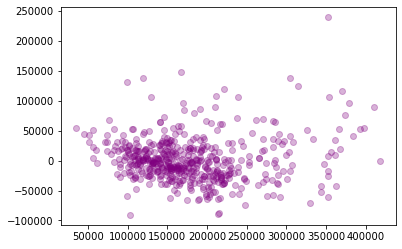

In [30]:
plt.scatter(lr_pred, lr_residuals, 
           c = 'purple', alpha = .3);

We can see that as the residuals are fairly standard except for the few outliers where the model predicted above the actual score for a mjaority of the homes, evened out by a few outliers with very high actual prices. 

This could be explained by outleirs we explored in the EDA, with some larger basements or deck sizes.

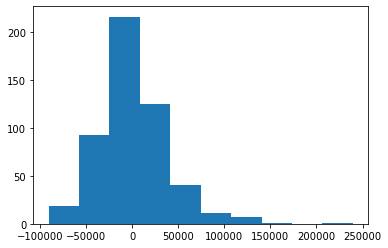

In [31]:
plt.hist(lr_residuals);

Here we can see the distribution to confirm our understanding of our model over predicting most houses at or below the actual price, with some outliers who's high prices were not accounted for by the features we used in this model.

# Coefficients and Intercept

In [32]:
lr_coef = lr_model.coef_
lr_coef

array([-8.49009134e+03,  2.39376709e+01,  3.42875986e+04,  1.42696473e+04,
        4.32100077e+01,  4.34505102e+01, -5.58534037e+03, -2.83671152e+04,
        2.49705035e+04,  2.47739914e+04,  5.42607618e+04,  1.34765618e+04,
        1.65012514e+04, -1.06048350e+04,  7.06550660e+03,  6.36366948e+04,
        4.55185883e+04,  0.00000000e+00])

In [33]:
X.columns

Index(['bsmt_half_bath', 'bsmt_finished', 'kitchen_qual', 'bsmt_qual',
       'total_bsmt_sf', 'wood_deck_sf', 'bsmt_full_bath', 'garage_type_2Types',
       'garage_type_Attchd', 'garage_type_Basment', 'garage_type_BuiltIn',
       'garage_type_CarPort', 'garage_type_Detchd', 'garage_cars_1.0',
       'garage_cars_2.0', 'garage_cars_3.0', 'garage_cars_4.0',
       'garage_cars_5.0'],
      dtype='object')

In [34]:
coef_df = pd.DataFrame({'feature': X.columns,
              'coef': lr_coef})

coef_df[(coef_df['coef'] == 0)].sort_values('coef')


,feature,coef
17,garage_cars_5.0,0.0


The \$0 increase in value of a home with all else held constant for 5 car garages could be potentially due to lack of data, as most houses do not have this number of garages. It would warrant more investigation on whether, with enough data, larger garages have a linear relationship, or if there is one size that is the most lucrative.

In [35]:
coef_df.sort_values('coef')

,feature,coef
7,garage_type_2Types,-28367.115164
13,garage_cars_1.0,-10604.835039
0,bsmt_half_bath,-8490.091335
6,bsmt_full_bath,-5585.340369
17,garage_cars_5.0,0.000000
1,bsmt_finished,23.937671
4,total_bsmt_sf,43.210008
5,wood_deck_sf,43.450510
14,garage_cars_2.0,7065.506604
11,garage_type_CarPort,13476.561765


# Interpretation

With all other values held constant, the best garage size is that of a 3 car garage, adding a value of \$63,636 to a home. 

A builtin garage is the best type, adding \$54,260 to a home's price holding all other features in this model constant. 

Looking at basement quality (height), which is on 5 point scale: <70 inches to >=100 inches, with 0 being no basement. 
For every 10 inches you add to a basement, the home value increases by \$14,270. 

Every 1 foot of square feet that is finished adds \$24 to the home value.

We can see that bathrooms in the basement actually decrease the value of the home, with every 1 half bath detracting \$8,490 dollars from the home value and each full bath added detracting \\$5,885 dollars.  

Is this because the only bathrooms in the house are in the basement? 

# Test Data Modeling

In [36]:
test['garage_cars'].value_counts()

2    467
1    254
3    110
0     44
4      3
Name: garage_cars, dtype: int64

In [37]:
features = [c for c in focus_features if 
            (c != 'saleprice') & (c != 'id') & (c not in drop_lst)]

y = train['saleprice']

In [38]:
X = train[set(features)]
X_test = test[set(features)]

In [39]:
X = pd.get_dummies(X, columns = ['garage_type'], drop_first=True)
X = pd.get_dummies(X, columns = ['garage_cars'], drop_first=True)

X_test = pd.get_dummies(X_test, columns = ['garage_type'], drop_first=True)
X_test = pd.get_dummies(X_test, columns = ['garage_cars'], drop_first=True)

In [40]:
X_test.columns

Index(['bsmt_half_bath', 'bsmt_finished', 'kitchen_qual', 'bsmt_qual',
       'total_bsmt_sf', 'wood_deck_sf', 'bsmt_full_bath', 'garage_type_2Types',
       'garage_type_Attchd', 'garage_type_Basment', 'garage_type_BuiltIn',
       'garage_type_CarPort', 'garage_type_Detchd', 'garage_cars_1',
       'garage_cars_2', 'garage_cars_3', 'garage_cars_4'],
      dtype='object')

In [41]:
X.columns

Index(['bsmt_half_bath', 'bsmt_finished', 'kitchen_qual', 'bsmt_qual',
       'total_bsmt_sf', 'wood_deck_sf', 'bsmt_full_bath', 'garage_type_2Types',
       'garage_type_Attchd', 'garage_type_Basment', 'garage_type_BuiltIn',
       'garage_type_CarPort', 'garage_type_Detchd', 'garage_cars_1.0',
       'garage_cars_2.0', 'garage_cars_3.0', 'garage_cars_4.0',
       'garage_cars_5.0'],
      dtype='object')

In [42]:
X = X.rename(columns = {'garage_cars_3.0': 'garage_cars_3',
                             'garage_cars_4.0': 'garage_cars_4', 
                             'garage_cars_5.0': 'garage_cars_5',
                             'garage_cars_1.0': 'garage_cars_1',
                             'garage_cars_2.0': 'garage_cars_2'})

In [43]:
X.columns

Index(['bsmt_half_bath', 'bsmt_finished', 'kitchen_qual', 'bsmt_qual',
       'total_bsmt_sf', 'wood_deck_sf', 'bsmt_full_bath', 'garage_type_2Types',
       'garage_type_Attchd', 'garage_type_Basment', 'garage_type_BuiltIn',
       'garage_type_CarPort', 'garage_type_Detchd', 'garage_cars_1',
       'garage_cars_2', 'garage_cars_3', 'garage_cars_4', 'garage_cars_5'],
      dtype='object')

In [44]:
find_missing_test_columns(X,X_test)

['garage_cars_5']

In [45]:
X_test['garage_cars_5'] = 0

In [46]:
find_missing_test_columns(X,X_test)

[]

In [47]:
lr = LinearRegression(n_jobs = -1)
lr = lr.fit(X, y)

In [48]:
pred = lr.predict(X_test)

In [49]:
test['pred_price'] = pred

In [50]:
lr.coef_

array([-9.62135061e+03,  2.40166783e+01,  3.33118468e+04,  1.41641277e+04,
        4.32780134e+01,  3.83905311e+01, -5.86439837e+03, -2.41728675e+04,
        2.72945650e+04,  2.50671845e+04,  5.43346631e+04,  7.41743894e+03,
        1.68448538e+04, -1.25170848e+04,  5.05415636e+03,  6.53288769e+04,
        4.94614863e+04, -5.41596926e+02])

In [51]:
coef_df = pd.DataFrame({'feature': X.columns,
              'coef': lr_coef})

In [52]:
coef_df.sort_values('coef')

,feature,coef
7,garage_type_2Types,-28367.115164
13,garage_cars_1,-10604.835039
0,bsmt_half_bath,-8490.091335
6,bsmt_full_bath,-5585.340369
17,garage_cars_5,0.000000
1,bsmt_finished,23.937671
4,total_bsmt_sf,43.210008
5,wood_deck_sf,43.450510
14,garage_cars_2,7065.506604
11,garage_type_CarPort,13476.561765


# Further EDA For Presentation

<ipython-input-53-3339b4062529>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['CarPort', 'Basement', 'Detached', 'Attached', 'BuiltIn'],fontsize=20)


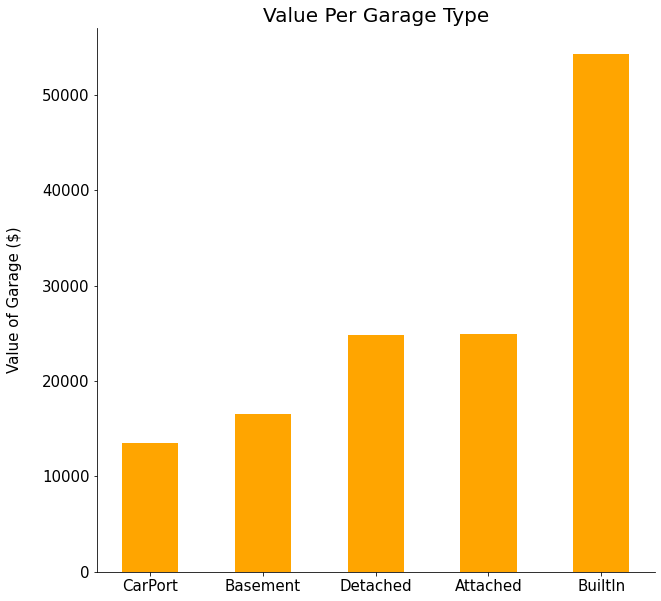

In [53]:
# plotting the garage sizes 

x_gar = ['Carport', 'Basement', 'Detached', 'Attached', 'BuiltIn']
y_gar = [13476, 16501, 24773, 24970, 54260]

plt.figure(figsize=(10, 10))


# plot a bar chart
plt.bar(width = .5, x = x_gar, height = y_gar, color = 'orange' )
ax = plt.gca()
ax.set_xticklabels(['CarPort', 'Basement', 'Detached', 'Attached', 'BuiltIn'],fontsize=20)
ax.set_ylabel('Value of Garage ($)',
              labelpad = 20, 
              fontsize = 15 )

ax.set_title('Value Per Garage Type', size = 20)
ax.spines["bottom"].set_position(("data", 0))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

major_ticks = np.arange(0, 50_000+1, 10_000)

ax.set_yticks(major_ticks)
ax.set_yticks(major_ticks, minor=True)

ax.tick_params(axis = 'both', which = 'major', labelsize = 15);


**Interpretation**
With all else held constant, the value different garage types to a house all add to the house's predicted price.  
However, when choosing betwene a Carport and a basement garage, as well as between Detached and Attached garges, there is not a large difference in the added value, so production factors as well as lot size would be useful to take into account. 

<ipython-input-54-a0632d155043>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['1 Car', '2 Cars', '4 Cars', '3 Cars'],fontsize=16)


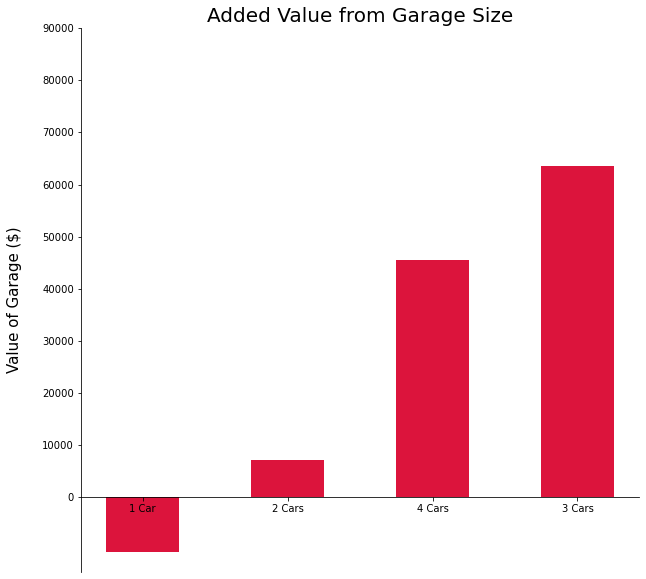

In [54]:
# plotting the garage sizes 

x_gar = ['garage_cars_3.0', 'garage_cars_4.0', 'garage_cars_2.0', 'garage_cars_1.0']
y_gar = [63637, 45518, 7065, -10604]

plt.figure(figsize=(10, 10))


# plot a bar chart
plt.bar(width = .5, x = x_gar[::-1], height = y_gar[::-1], color = 'crimson' )
ax = plt.gca()
ax.set_xticklabels(['1 Car', '2 Cars', '4 Cars', '3 Cars'],fontsize=16)
ax.set_ylabel('Value of Garage ($)',
              labelpad = 20, 
              fontsize = 15 )
ax.set_title('Added Value from Garage Size', size = 20)
ax.spines["bottom"].set_position(("data", 0))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

major_ticks = np.arange(0, 100_000, 10_000)

ax.set_yticks(major_ticks)
ax.set_yticks(major_ticks, minor=True);


**Interpretation**
With all else held constant, the added value of a 1 car garage to a house is in the negative while 2 car and larger garages seem to increase in value. 

Therefore, the best investment is to add a garage that fits at least 2 cars. 

[source for spines](https://stackoverflow.com/questions/60519582/matplotlib-bar-chart-negative-values-below-x-axis)
[source for y spacing](https://stackoverflow.com/questions/24943991/change-grid-interval-and-specify-tick-labels-in-matplotlib)

In [119]:
coef_df[coef_df['feature'] == 'bsmt_finished'], coef_df[coef_df['feature'] == 'total_bsmt_sf']

(         feature       coef
 5  bsmt_finished  23.937671,
          feature       coef
 2  total_bsmt_sf  43.210008)

In [120]:
# the minimum size for a 2 car garage in the basement. 
(24*20) + 43*20

1340

In [121]:
coef_df[coef_df['feature'] == 'garage_cars_2.0']

,feature,coef


In [122]:
coef_df[coef_df['feature'] == 'garage_type_Basment']['coef']

9    24773.991429
Name: coef, dtype: float64

[2 car garage sqfr](https://shedsunlimited.net/blog/2-car-garage-dimensions#:~:text=In%20short%2C%20the%20minimum%20dimensions,will%20go%20a%20long%20way.)

In [123]:
7065+24773

31838

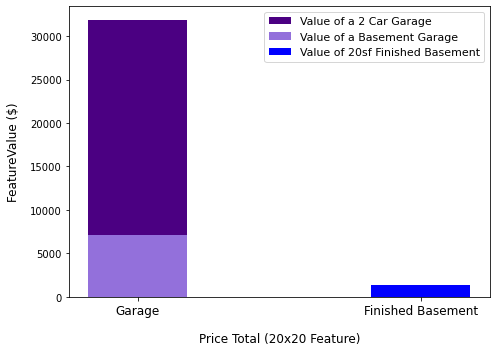

In [124]:
# plotting bar plot of scores when tests are and are not required

labels = ['Garage', 'Finished Basement']

lst_one = [7065+24773, 0]
lst_two =  [7065, 0]
lst_three = [0, 1340]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (7,5))
rects1 = ax.bar(x, lst_one, width, label='Value of a 2 Car Garage', color = 'indigo')
rects2 = ax.bar(x, lst_two, width, label='Value of a Basement Garage', color = 'mediumpurple')
rects3 = ax.bar(x, lst_three, width, label='Value of 20sf Finished Basement', color = 'blue')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('FeatureValue ($)', fontsize = 12, labelpad = 10)
ax.set_xlabel('Price Total (20x20 Feature)', fontsize = 12, labelpad = 15)
ax.set_title('',
             fontsize = 20,
             pad= 30, 
             fontweight='bold')

# setting up the graph
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize = 12)
ax.legend(loc = 'upper right', fontsize = 11, facecolor = 'white')

fig.tight_layout()

plt.show();


**Interpretation**
The added value of finishing a 20x20 basement is much lower than making that part of the basement into a 2 car garage. Therefore, if choosing between the two, it is worth making the space into a garage when possible.

In [125]:
test[(test['garage_type']=='Basment') & (test['garage_cars']==2)].mean()

id                               1498.400000
ms_subclass                       100.000000
lot_frontage                       80.000000
lot_area                         9830.400000
street                              2.000000
                                   ...      
bsmt_finished_with_halfbath         0.000000
overall_qual_cond                  38.800000
finished_n_total               559777.000000
bsmt_size_fin_sf               559777.000000
pred_price                     155671.746034
Length: 64, dtype: float64

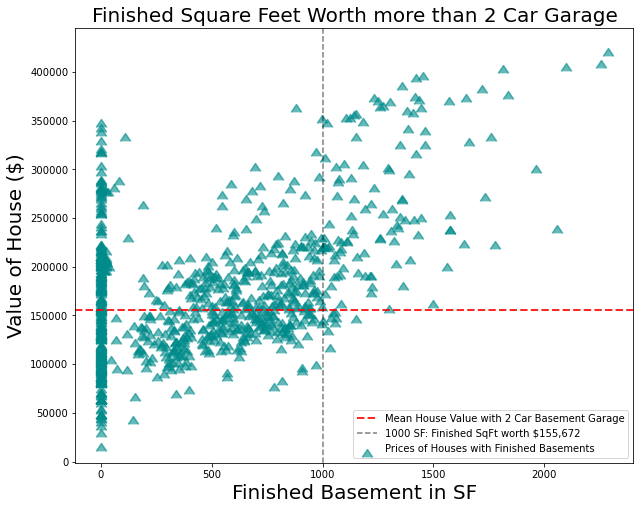

In [139]:
plt.figure(figsize = (10,8))
plt.scatter(test['bsmt_finished'],
            test['pred_price'], 
            color = 'darkcyan',
            alpha = .6, marker=6,
            s = 110,
           label = 'Prices of Houses with Finished Basements');

plt.axhline(155672, c = 'red',
           linestyle = '--',
            linewidth = 2, 
            alpha = .85, 
            label = 'Mean House Value with 2 Car Basement Garage')

plt.axvline(1000, c = 'black', 
            label = '1000 SF: Finished SqFt worth $155,672', 
           linestyle = '--',
            lw = 1.5, 
           alpha = .5, ymax = 16000)

plt.xlabel('Finished Basement in SF', fontsize = 20)
plt.ylabel('Value of House ($)', fontsize = 20)
plt.title('Finished Square Feet Worth more than 2 Car Garage', fontsize = 20)


plt.legend()

**Interpretation** 

The mean predicted price of houses with basement-2-car garages is at \$155,672. Looking at the scatterplot, we can see that the intersection of the value and the predicted price of a majority of houses with finished basements occurs at 1000 square feet. 

In order to get more value out of a finished basement than a 20x20 garage, you would need a basement of at least 1000 square feet to renovate.

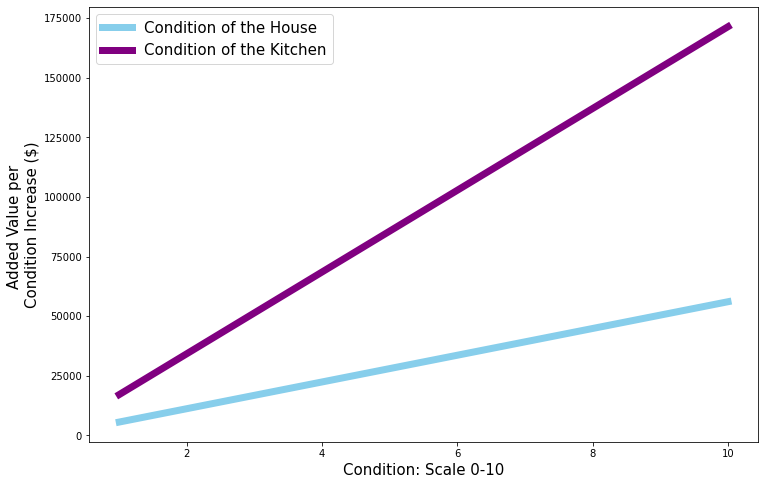

In [127]:
# Data
df=pd.DataFrame({'x_values': range(1,11),
                 'Condition of the House': [5607*i for i in range(1,11)], 
                 'Condition of the Kitchen':[(34287/2)*i for i in range(1,11)]})
 
    
# bigger plt
plt.figure(figsize = (12, 8))

# multiple line plots
plt.plot( 'x_values', 'Condition of the House', data=df, marker='', 
         markerfacecolor='purple', markersize=12,
         color='skyblue', linewidth=7)
plt.plot( 'x_values', 'Condition of the Kitchen',
         data=df, marker='', color='purple', linewidth=7)
# show legend
plt.legend(fontsize = 15)
plt.xlabel('Condition: Scale 0-10', fontsize = 15)
plt.ylabel('Added Value per \nCondition Increase ($)', fontsize = 15)


# show graph
plt.show()

**Interpretation**
The coefficient for Kitchen qual is much higher than House quality so it is recommended to focus on making a kitchen of excellent quality rather than the entire house, as the best investment.

In [128]:
14269.647276

14269.647276

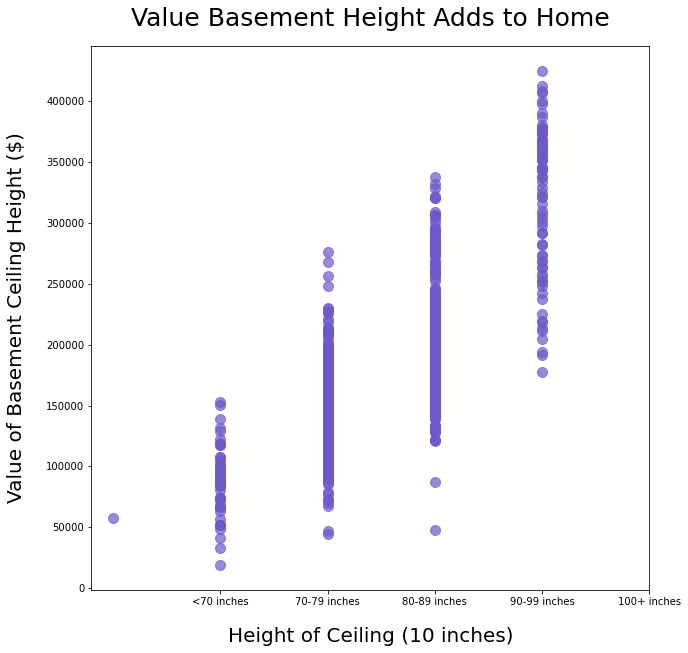

In [137]:
# plotting the basment heights 



plt.figure(figsize=(10, 10))


# plot a bar chart
plt.scatter(x = test['bsmt_qual'], y =test['pred_price'], 
            color = 'slateblue' ,
            s =100, 
           alpha = .7)



plt.ylabel('Value of Basement Ceiling Height ($)',
              labelpad = 20, 
              fontsize = 20 )
plt.xticks(np.arange(5), ['100+ inches',
                           '90-99 inches', 
                           '80-89 inches', 
                           '70-79 inches',
                           '<70 inches'][::-1])

plt.xlabel('Height of Ceiling (10 inches)', fontsize = 20, labelpad = 20)
plt.title('Value Basement Height Adds to Home', size = 25, pad = 20)

ax.tick_params(axis = 'both', which = 'major', labelsize = 15);

**Interpretation**

For every 10 inches added to a basement, we can see there is an impact on the value of the home. Despite the wide dispersion of house values at each height interval, both the minimum and maximum home values increase, albeit with some overlap in prices. 

Recommendations would be to combine basement ceiling raising with finished basements to add the most value to the homes. 

# Final Recommendations

The final recommendations for garage rennovations would be to add a two or three car gargae. If space is a concern, in terms of total home square feet or lot size, then converting a basement to a garage is a lucrative option. A 20x20 garage (2 car garage) in the basement can add \$31,000 dollars to the home value. 

When building a garage, it is worth considering the size that it is taking away from the basement. Finished basements do add to the home value, but at what point is it worth it to finish the basement at the expense of the square feet taken up by a garage? 

The mean of homes with a basement garage is about \$155,600. To beat that price with a finished basement, you would need at least 1,000 square feet. 

The best way to add value to the house with a basement is to both raise the ceilings and finish the basement, without adding bathrooms. 
